# Boosting Classifiers

In [1]:
import pandas as pd

# Import data
train = pd.read_csv("../data/train.csv").sort_values('id')
train_df = train.loc[:, train.columns != 'price']
train_prices = train['price'].values

test_df = pd.read_csv("../data/test.csv").sort_values('id')

In [2]:
from data_processing import preprocessing

# Combine data for processing (important for one-hot encoding)
combined_df = pd.concat([test_df, train_df], ignore_index=True)

# Select which columns to include in the analysis
selected_features = list(combined_df.columns)
to_remove = ['id', 'scrape_id', 'last_scraped', 'name', 'description', 
             'picture_url', 'host_id', 'host_name', 'calendar_last_scraped',
             'bathrooms_text']
for col in to_remove:
  selected_features.remove(col)

# Process combined data
processed_data = preprocessing(combined_df.copy(), selected_features)

test_processed = processed_data.iloc[:len(test_df)]
train_processed = processed_data.iloc[len(test_df):]

### Testing parameters with 5-fold CV and grid search

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Prepare data
X = train_processed
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_prices)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.5, 0.15, 0.4],
    'n_estimators': [50, 100, 150],
}

# Use GridSearchCV to perform 5-fold cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 150}


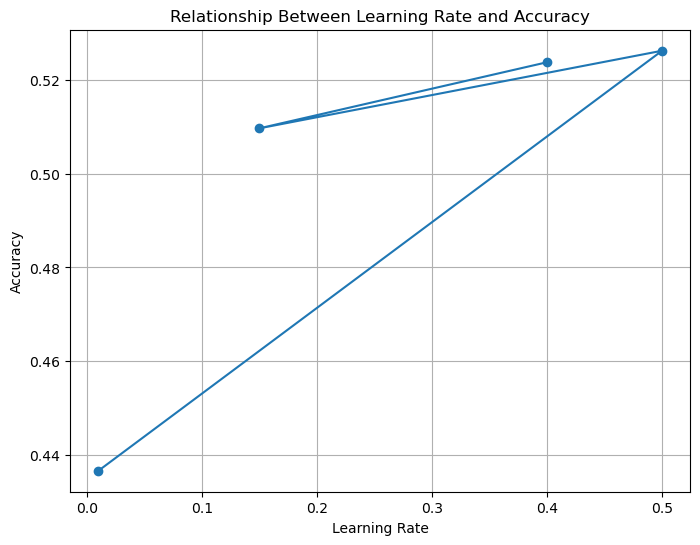

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Keep the other parameters constant
max_depth_value = 3
n_estimators_value = 100

# Define the learning rates to be tested
learning_rates = [0.01, 0.5, 0.15, 0.4]

# Lists to store results
accuracy_results = []

# Perform GridSearchCV for each learning rate
for learning_rate_value in learning_rates:
    xgb_classifier = xgb.XGBClassifier(max_depth=max_depth_value, n_estimators=n_estimators_value, learning_rate=learning_rate_value)
    grid_search = GridSearchCV(xgb_classifier, param_grid={}, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    accuracy_results.append(grid_search.best_score_)


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, accuracy_results, marker='o')
plt.title('Relationship Between Learning Rate and Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


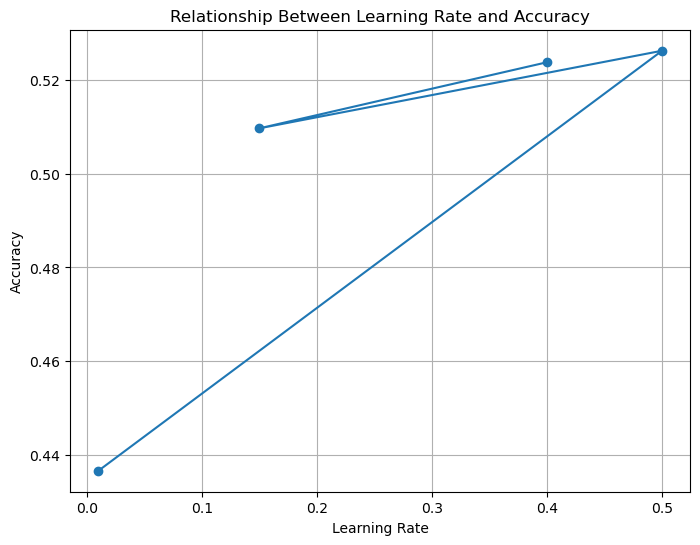

In [21]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, accuracy_results, marker='o')
plt.title('Relationship Between Learning Rate and Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [19]:
# Get the results of the cross-validation
cv_results = grid_search.cv_results_

for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Accuracy: {mean_score:.4f} (+/- {std_score:.4f}) for params: {params}")

Accuracy: 0.4307 (+/- 0.0065) for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.4335 (+/- 0.0065) for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.4410 (+/- 0.0095) for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Accuracy: 0.4668 (+/- 0.0066) for params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Accuracy: 0.4772 (+/- 0.0101) for params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.4826 (+/- 0.0088) for params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}
Accuracy: 0.5119 (+/- 0.0114) for params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.5182 (+/- 0.0075) for params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.5234 (+/- 0.0090) for params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 150}
Accuracy: 0.5224 (+/- 0.0053) for params: {'learning_rate': 0.5, 'max_depth': 5

In [9]:
from sklearn.metrics import accuracy_score

# Predict on the test set using the best model
y_pred = best_xgb.predict(X_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.84%


### Training on full train data

In [18]:
# Prepare data
X_train = train_processed
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_prices)

# Build classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',
                                       learning_rate=0.2,
                                       max_depth=8,
                                       n_estimators=250)

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [16]:
# Get predictions on test data
X_test = test_processed

predictions = xgb_classifier.predict(X_test)

# Store predictions in dataframe
predictions_df = pd.DataFrame({'id': X_test.index, 'price': predictions})

In [17]:
# Save predictions to output file
predictions_df.to_csv('../predictions/xgb_7.csv', index=False)